In [1]:
import glob
import pandas
import geopandas
import geopy
import shapely

SOCAL_FEET = 2229
WGS84 = 4326

In [174]:
files = sorted(glob.glob("data/CCRS/*crashes.csv"))

In [419]:
centerline = geopandas.read_file("data/centerline.geojson")

In [4]:
def get_hyperion_fountain_crashes(path):
    print(f"Processing {path}")

    # Load crash data
    crashes = (
        pandas
        .read_csv(path, dtype=str, dtype_backend="pyarrow")
        .rename(columns=lambda c: c.replace("\t", ""))
    )
    # Convert to geodataframe
    crashes = geopandas.GeoDataFrame(
        crashes,
        geometry=geopandas.points_from_xy(
            crashes.Longitude,
            crashes.Latitude,
            crs=f"EPSG:{WGS84}"
        )
    )

    # Filter to crashes that are in LA and either have Fountain or
    # Hyperion in the primary or secondary streets.
    hyperion_fountain_crashes = crashes[
        crashes["City Name"].str.lower().str.contains("los angeles") & (
            crashes.PrimaryRoad.str.lower().str.contains("hyperion") |
            crashes.PrimaryRoad.str.lower().str.contains("fountain") |
            crashes.SecondaryRoad.str.lower().str.contains("hyperion") |
            crashes.SecondaryRoad.str.lower().str.contains("fountain")
        )
    ]


    # Geocode crashes that don't already have a lat/lon associated with them
    hyperion_fountain_crashes = hyperion_fountain_crashes.assign(
        address = (
            hyperion_fountain_crashes.PrimaryRoad + " at " +
            hyperion_fountain_crashes.SecondaryRoad + " Los Angeles, CA"
        )
    )
    geolocator = geopy.geocoders.ArcGIS()
    def _geocode(a):
        loc = geolocator.geocode(a)
        return shapely.geometry.Point(loc.longitude, loc.latitude)
    
    def _get_geom(record):
        if shapely.is_empty(record.geometry) or not shapely.is_valid(record.geometry):
            return _geocode(record.address)
        else:
            return record.geometry
    hyperion_fountain_crashes = (
        hyperion_fountain_crashes
        .set_geometry(hyperion_fountain_crashes.apply(_get_geom, axis=1))
    )

    # Futher filter for crashes that happen within a 100ft buffer of the study area
    hyperion_fountain_crashes = (
        hyperion_fountain_crashes[
            hyperion_fountain_crashes
            .to_crs(epsg=SOCAL_FEET)
            .within(centerline.to_crs(epsg=SOCAL_FEET).buffer(100.).union_all())
        ]
    )
    return hyperion_fountain_crashes

In [5]:
dfs = [get_hyperion_fountain_crashes(f) for f in files]

Processing data/CCRS/hq1d-p-app52dopendataexport2016crashes.csv
Processing data/CCRS/hq1d-p-app52dopendataexport2017crashes.csv
Processing data/CCRS/hq1d-p-app52dopendataexport2018crashes.csv
Processing data/CCRS/hq1d-p-app52dopendataexport2019crashes.csv
Processing data/CCRS/hq1d-p-app52dopendataexport2020crashes.csv
Processing data/CCRS/hq1d-p-app52dopendataexport2021crashes.csv
Processing data/CCRS/hq1d-p-app52dopendataexport2022crashes.csv
Processing data/CCRS/hq1d-p-app52dopendataexport2023crashes.csv
Processing data/CCRS/hq1d-p-app52dopendataexport2024crashes.csv
Processing data/CCRS/hq1d-p-app52dopendataexport2025crashes.csv


In [7]:
gdf = pandas.concat(dfs)

In [8]:
gdf.to_file("data/hyperion_fountain_crashes.geojson")

In [221]:
import altair

In [263]:
import re

def normalize_road(s):
    # Remove parentheticals like "(1300 Block)"
    s = re.sub(r"\s*\([^)]*\)", "", s)
    return (
        s
        .lower()
        .strip(" \t.")
        .removesuffix("n/b").strip()
        .removesuffix("s/b").strip()
        .removesuffix("ave")
        .removesuffix("av")
        .removesuffix("st")
        .removesuffix("ct")
        .removesuffix("dr")
        .removesuffix("bl")
        .removeprefix("w ")
        .removeprefix("s ")
        .removeprefix("n ")
        .removeprefix("e ")
        .removeprefix("west ")
        .strip(" \t.")
        .replace("delongpre", "de longpre")
        .replace("frountain", "fountain")
        .replace("hyperion av 2538", "evans")
        .title()
    )
normalize_road("Bates Ave N/B (1300 Block)")

'Bates'

In [275]:
gdf = gdf.assign(
    timestamp=pandas.to_datetime(gdf["Crash Date Time"]),
    n_killed=gdf.NumberKilled.astype(int),
    n_injured=gdf.NumberInjured.astype(int),
    primary_road=gdf.PrimaryRoad.apply(normalize_road),
    secondary_road=gdf.SecondaryRoad.apply(normalize_road),
    pedestrian_involved=gdf.PedestrianActionCode != "A",
    n_crashes=1
)
    

In [276]:
def get_intersection(record):
    if record.primary_road == "Fountain" and record.secondary_road == "Hyperion":
        return "Hyperion/Fountain"
    elif record.primary_road in ("Hyperion", "Fountain"):
        return record.primary_road + "/" + record.secondary_road
    elif record.secondary_road in ("Hyperion", "Fountain"):
        return record.secondary_road + "/" + record.primary_road
    else:
        return record.primary_road + "???" + record.secondary_road

gdf = gdf.assign(
    intersection = gdf.apply(get_intersection, axis=1)
)

In [277]:
to_chart = gdf[["primary_road", "secondary_road", "timestamp", "n_injured", "n_killed", "intersection"]]

In [879]:
order = [
    "Hyperion/Rowena",
    "Hyperion/Monon",
    "Hyperion/Griffith Park",
    "Hyperion/Evans",
    "Hyperion/Tracy",
    "Hyperion/Entrance",
    "Hyperion/Scotland",
    "Hyperion/Lyric",
    "Hyperion/Udell",
    "Hyperion/De Longpre",
    "Hyperion/Fernwood",
    "Hyperion/Fountain",
    "Fountain/Sanborn",
    "Fountain/Manzanita",
    "Fountain/Myra",
    "Fountain/Bates",
    "Fountain/Effie",
    "Fountain/Talmadge",
    "Fountain/Hoover",
    "Fountain/Sunset",
]
(
    altair.Chart(to_chart[to_chart["intersection"].isin(order)], width=600, height=400)
    .mark_circle()
    .encode(
        x=altair.X("timestamp:T", title="Date"),
        y=altair.Y("intersection:N", sort=order, title="Intersection"),
        size=altair.Size("n_injured:Q", title="Number injured"),
    )
)

alt.Chart(...)

In [279]:
gdf[~gdf["intersection"].str.strip().isin(order)][["PrimaryRoad", "SecondaryRoad", "intersection"]

,PrimaryRoad,SecondaryRoad,intersection
347046,Hyperion,Greenwater Rd,Hyperion/Greenwater Rd
333582,Commerce,Fountain,Fountain/Commerce
139796,Whitley,Fountain,Fountain/Whitley
402857,El Center,Fountain,Fountain/El Center


In [373]:
by_intersection = (
    gdf
    [gdf["intersection"].isin(order)]
    [[
        "intersection",
        "n_injured",
        "n_killed",
        "n_crashes",
        "pedestrian_involved",
        "geometry",
    ]]
    .dissolve("intersection", aggfunc="sum")
    .to_crs(epsg=SOCAL_FEET)
)
by_intersection = (
    by_intersection
    .set_geometry(by_intersection.geometry.representative_point())
    .to_crs(epsg=WEBMERCATOR)
)

In [374]:
import contextily
import geopandas
import matplotlib.pyplot as plt
import pandas
import shapely
import numpy

In [518]:
west = -118.286
south = 34.094
east = -118.269
north = 34.111

cx = (slice(west, east), slice(south, north))

WEBMERCATOR = 3857

In [519]:
bounds = (
    geopandas.GeoDataFrame(
        geometry=[shapely.geometry.box(west, south, east, north)],
        crs="EPSG:4326",
    )
    .to_crs(epsg=WEBMERCATOR)
    .bounds
    .iloc[0]
)

In [526]:
img, extent = contextily.bounds2img(
    west,
    south,
    east,
    north,
    zoom=15,
    ll=True,
    source=contextily.providers.CartoDB.Voyager,
)

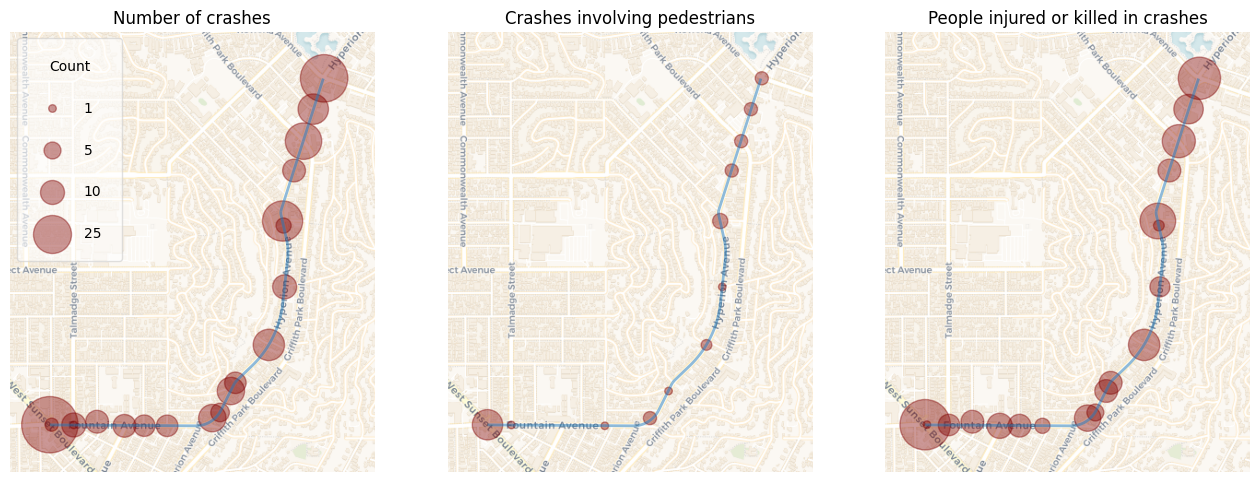

In [528]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,20))
plt.close(fig)


metrics = [
    by_intersection.n_crashes,
    by_intersection.pedestrian_involved,
    by_intersection.n_killed + by_intersection.n_injured
]
labels = [
    "Number of crashes",
    "Crashes involving pedestrians",
    "People injured or killed in crashes",
]

for ax, metric, label in zip(axes, metrics, labels):
    ax.imshow(img, extent=extent)
    ax.set_xlim(bounds.minx, bounds.maxx)
    ax.set_ylim(bounds.miny, bounds.maxy)
    ax.set_autoscale_on(False)
    centerline.to_crs(epsg=WEBMERCATOR).plot(ax=ax, linewidth=2, alpha=0.5)
    ax.set_title(label)
    ax.axis("off");
    (
        by_intersection
        .to_crs(epsg=WEBMERCATOR)
        .plot(
            ax=ax,
            markersize=metric*30,
            alpha=0.40,
            c="maroon",
        )
    )

    if label == "Number of crashes":
        legend_handles = [
            ax.scatter([], [], s=v*30, c="maroon", alpha=0.40, label=str(v))
            for v in [1, 5, 10, 25]
        ]
        ax.legend(
            handles=legend_handles,
            title="Count",
            loc="upper left",
            frameon=True,
            framealpha=0.6,
            labelspacing=2,
            borderpad=1.5,
            handletextpad=1.3
        )
fig

In [874]:
# Color scheme for pie charts - try: "category10", "category20", "set1", "set2", "set3", "pastel1", "pastel2", "tableau10", "tableau20"
SCHEME = "dark2"

In [869]:
other_party = (
    gdf
    .fillna("NON-COLLISION")
    .replace("MOTOR VEHICLE ON OTHER ROADWAY", "OTHER MOTOR VEHICLE")
    .replace("OTHER MOTOR VEHICLE", "MOVING MOTOR VEHICLE")
    .replace("OTHER OBJECT", "FIXED OBJECT")
    .assign(category=lambda g: g.MotorVehicleInvolvedWithDesc.str.capitalize().str.wrap(12))
)

base = (
    altair.Chart(other_party).encode(
        theta=altair.Theta("count(category)").stack(True),
        color=altair.Color(
            "category",
            scale=altair.Scale(scheme=SCHEME),
        ).legend(None)
    )
)

pie = base.mark_arc(outerRadius=120, opacity=0.3)
text = base.mark_text(radius=150, size=12, lineBreak="\n").encode(
    text="category:N",
    color=altair.value('black'),
) + base.mark_text(radius=80, size=14).encode(
    text="count(category):Q",
    color="category:N",
)

other_party_chart = (pie + text).properties(title="Other object in crash")

In [875]:
weather = (
    gdf
    .assign(category=gdf["Weather 1"].str.capitalize())
    [["category"]]
    .fillna("Clear")
)

base = (
    altair.Chart(weather).encode(
        theta=altair.Theta("count(category)").stack(True),
        color=altair.Color("category", scale=altair.Scale(scheme=SCHEME)).legend(None)
    )
)

pie = base.mark_arc(outerRadius=120, opacity=0.3)
text = base.mark_text(radius=150, size=12, lineBreak="\n").encode(
    text="category:N",
    color=altair.value('black'),
) + base.mark_text(radius=80, size=14).encode(
    text="count(category):Q",
    color="category:N",
)

weather_chart = (pie + text).properties(title="Weather conditions")

In [871]:
hit_run = (
    gdf[["HitRun"]]
    .fillna("No")
    .replace("M", "Yes")
    .replace("F", "Yes")
    .rename(columns={"HitRun": "category"})
)

base = (
    altair.Chart(hit_run).encode(
        theta=altair.Theta("count(category)").stack(True),
        color=altair.Color("category", scale=altair.Scale(scheme=SCHEME)).legend(None)
    )
)

pie = base.mark_arc(outerRadius=120, opacity=0.3)
text = base.mark_text(radius=150, size=12, lineBreak="\n").encode(
    text="category:N",
    color=altair.value('black'),
) + base.mark_text(radius=80, size=14).encode(
    text="count(category):Q",
    color="category:N",
)

hit_run_chart = (pie + text).properties(title="Hit and run?")

In [876]:
lighting = (
    gdf
    .assign(category=gdf[" LightingDescription"].str.capitalize())
    .replace("Dark-street lights", "Dark")
    .replace("Dark-no street lights", "Dark")
    [["category"]]
    .fillna("Daylight")
)

base = (
    altair.Chart(lighting).encode(
        theta=altair.Theta("count(category)").stack(True),
        color=altair.Color("category", scale=altair.Scale(scheme=SCHEME)).legend(None)
    )
)

pie = base.mark_arc(outerRadius=120, opacity=0.3)
text = base.mark_text(radius=150, size=12, lineBreak="\n").encode(
    text="category:N",
    color=altair.value('black'),
)  + base.mark_text(radius=80, size=14).encode(
    text="count(category):Q",
    color="category:N",
)


lighting_chart = (pie + text).properties(title="Lighting conditions")

In [878]:
((other_party_chart | hit_run_chart) & (lighting_chart | weather_chart))

alt.VConcatChart(...)